# Implementación de strategia Ramdom Forest Federado para la Base de Datos Adidas US SALES

## Instalaciones y detalles

Este notebook adapta la estrategia de **Federated Random Forest** desarrollada por Cotorobai et al. (2025) al proyecto de Adidas, permitiendo particionar datos, levantar servidores federados y entrenar modelos de forma distribuida y segura.

Para empezar, instala las dependencias necesarias:



In [2]:
#pip install -r requirements.txt


In [3]:
#%pip install -e ..


A continuación se muestran los detalles de la publicación original y la licencia bajo la que se distribuye el código:


@inproceedings{cotorobai2025federated,
  title     = {A Federated Random Forest Solution for Secure Distributed Machine Learning},
  author    = {Cotorobai, Alexandre and Silva, Jorge Miguel and Oliveira, José Luis},
  booktitle = {Proceedings of the IEEE International Conference on Bioinformatics and Biomedicine (CBMS)},
  year      = {2025},
  pages     = {–},      % actualizar cuando esté disponible
  doi       = {–}       % actualizar cuando esté disponible
}

Licencia

MIT License

Copyright (c) 2024 Alexandre Cotorobai

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Imports y carga/limpieza

En esta sección vamos a cargar el fichero original de ventas de Adidas, aplicar limpieza y generar automáticamente un conjunto de particiones (nodos federados) según varios esquemas (`retailer_region`, `retailer_city`, `region`).  

La libreta está en src_rf/ImplementacionADatasetAdidadas/ por lo que los CSV resultantes se guardarán en una carpeta `nodos/` situada en la raíz de `src_rf`.

In [4]:
import random
import os
import pandas as pd
from pathlib import Path
from ucimlrepo import fetch_ucirepo
from sklearn.utils import resample
from pathlib import Path

In [5]:
# --------------------------------------------------------------------------
# 1.  Cargamos y limpiamos el Excel  (tu función se queda tal cual)
# --------------------------------------------------------------------------

#  Ruta al Excel de ventas
DATA_FILE = Path.cwd().parent.parent / "datos" / "Adidas US Sales Datasets.xlsx"

#  Función actualizada de carga y limpieza
def load_clean_adidas_data(ruta_excel: Path) -> pd.DataFrame:

    df = pd.read_excel(ruta_excel)
    
    # 1Eliminar las primeras tres filas que contienen datos irrelevantes
    df = df.drop([0, 1, 2])

    # Restablecer índices tras eliminar filas y renombrar columnas usando fila 3
    header_row = df.loc[3]
    df = df.rename(columns=header_row)
    
    # Eliminar primera columna vacía
    df = df.drop(df.columns[0], axis=1)
    
    # Eliminar fila 3 usada como cabecera y resetear índice
    df = df.drop(index=3).reset_index(drop=True)
    
    
    # Filtrar filas con 'Invoice Date' inválida y convertir a datetime
    valid_mask = pd.to_datetime(df['Invoice Date'], errors='coerce').notna()
    df = df[valid_mask]
    df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])
    
    print(" Primeras filas tras conversión 'Invoice Date':")
    display(df.head())
    
    # Definir variables
    variables_categoricas = ['Retailer', 'Region', 'State', 'City', 'Product', 'Sales Method']
    variables_numericas = ['Price per Unit', 'Total Sales', 'Operating Profit', 'Operating Margin']
    variable_objetivo = ['Units Sold']
    
    print("• Variables categóricas:", variables_categoricas)
    print("• Variables numéricas:", variables_numericas)
    print("• Variable objetivo:", variable_objetivo)
    
    # Conversión de tipos
    for col in variables_categoricas:
        if col in df:
            df[col] = df[col].astype('category')
    for col in variables_numericas + variable_objetivo:
        if col in df:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Mostrar tipos de datos resultantes
    print("\n Tipos de datos final:")
    display(df.dtypes)
    
    return df
#  Prueba de la función
df = load_clean_adidas_data(DATA_FILE)
print("\n DataFrame limpio preparado.")

 Primeras filas tras conversión 'Invoice Date':


,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50,1200,600000,300000,0.5,In-store
1,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50,1000,500000,150000,0.3,In-store
2,Foot Locker,1185732,2020-01-03,Northeast,New York,New York,Women's Street Footwear,40,1000,400000,140000,0.35,In-store
3,Foot Locker,1185732,2020-01-04,Northeast,New York,New York,Women's Athletic Footwear,45,850,382500,133875,0.35,In-store
4,Foot Locker,1185732,2020-01-05,Northeast,New York,New York,Men's Apparel,60,900,540000,162000,0.3,In-store


• Variables categóricas: ['Retailer', 'Region', 'State', 'City', 'Product', 'Sales Method']
• Variables numéricas: ['Price per Unit', 'Total Sales', 'Operating Profit', 'Operating Margin']
• Variable objetivo: ['Units Sold']

 Tipos de datos final:


Retailer                  category
Retailer ID                 object
Invoice Date        datetime64[ns]
Region                    category
State                     category
City                      category
Product                   category
Price per Unit             float64
Units Sold                   int64
Total Sales                float64
Operating Profit           float64
Operating Margin           float64
Sales Method              category
dtype: object


 DataFrame limpio preparado.


In [6]:
# Crea la tabla de conteos de categorías por variable
categorical_cols = ['Retailer', 'Region', 'State', 'City', 'Product', 'Sales Method']
category_counts = pd.DataFrame({
    'Column': categorical_cols,
    'Unique Categories': [df[col].nunique() for col in categorical_cols]
})

# Mostrar conteos de categorías
from IPython.display import display

print(" Conteo de categorías por variable:")
display(category_counts)



 Conteo de categorías por variable:


,Column,Unique Categories
0,Retailer,6
1,Region,5
2,State,50
3,City,52
4,Product,6
5,Sales Method,3


In [7]:
# --------------------------------------------------------------------------
# 2.  Parámetros básicos de modelado
# --------------------------------------------------------------------------

data_params = {
    "target": "Units Sold",
    "ignored_columns": [
        "Invoice Date",         # metadato irrelevante para el modelo
        "Total Sales",          # = Units Sold * Price per Unit
        "Operating Profit",     # depende de Units Sold
        "Operating Margin",     # idem
    ],
}

In [8]:
# --------------------------------------------------------------------------
# 3.  Función de *pre-procesado único*
# --------------------------------------------------------------------------

def preprocess_features(raw: pd.DataFrame, dp: dict) -> tuple[pd.DataFrame, pd.Series]:
    """Devuelve X numérico + y (sin hacer train/test split)."""
    y = raw[dp["target"]]

    X = (
        raw.drop(dp["ignored_columns"] + [dp["target"]], axis=1)
        .copy()
    )

    # a) One-hot para categorías pequeñas
    small_cats = ["Retailer", "Region", "Product", "Sales Method"]
    X = pd.get_dummies(X, columns=small_cats, drop_first=True)

    # b) Label-encoding para State / City
    for col in ["State", "City"]:
        X[col] = X[col].astype("category").cat.codes

    # tipo numérico homogéneo
    return X.astype("float64"), y


In [9]:
# --------------------------------------------------------------------------
# 4.  Plantilla global de columnas (se calcula **una vez**)
# --------------------------------------------------------------------------
X_full, _        = preprocess_features(df, data_params)
COL_TEMPLATE     = sorted(X_full.columns)              # lista ordenada
print(f" Plantilla de columnas: {len(COL_TEMPLATE)} features")

# las guardamos por si las necesito en otro notebook
import json, os
os.makedirs("artefactos", exist_ok=True)
Path("artefactos/template_cols.json").write_text(json.dumps(COL_TEMPLATE))

 Plantilla de columnas: 20 features


445

In [10]:
# --------------------------------------------------------------------------
# 5.  Función para exportar cada partición ya re-indexada
# --------------------------------------------------------------------------
def export_partition(df_part: pd.DataFrame, path: Path) -> None:
    """
    • Aplica el mismo pre-procesado.
    • Re-indexa al orden/longitud de COL_TEMPLATE.
    • Guarda CSV con X homogéneo + target.
    """
    X, y    = preprocess_features(df_part, data_params)
    X_fixed = X.reindex(columns=COL_TEMPLATE, fill_value=0.0)
    out     = pd.concat([X_fixed, y], axis=1)
    out.to_csv(path, index=False)


In [11]:
# --------------------------------------------------------------------------
# 6.  Particionado + exportación homogénea
# --------------------------------------------------------------------------
def partition_by_retailer_region(df):
    print("🔀 Particionando por Retailer + Region…")
    grupos = df.groupby(['Retailer','Region'], observed=True)
    particiones = {}
    for (retailer, region), sub in grupos:
        key = f"{retailer} - {region}"
        particiones[key] = sub.reset_index(drop=True)
        print(f"   • Nodo '{key}': {len(sub)} registros")
    return particiones

def partition_by_retailer_city(df):
    print("🔀 Particionando por Retailer + City…")
    grupos = df.groupby(['Retailer','City'], observed=True)
    particiones = {}
    for (retailer, city), sub in grupos:
        key = f"{retailer} - {city}"
        particiones[key] = sub.reset_index(drop=True)
        print(f"   • Nodo '{key}': {len(sub)} registros")
    return particiones

def partition_by_region(df):
    print("🔀 Particionando por Region…")
    grupos = df.groupby('Region', observed=True)
    particiones = {}
    for region, sub in grupos:
        key = region
        particiones[key] = sub.reset_index(drop=True)
        print(f"   • Nodo '{key}': {len(sub)} registros")
    return particiones


In [12]:
# --------------------------------------------------------------------------
# 7.  Creación de nodos y del hold-out procesado
# --------------------------------------------------------------------------

# Parámetros de evaluación
from sklearn.model_selection import train_test_split
from pathlib import Path

EVAL_FRAC = 0.2  # 20% para evaluación
SCHEMES = {
    "retailer_region": partition_by_retailer_region,
    "retailer_city":   partition_by_retailer_city,
    "region":          partition_by_region
}

#  Para cada esquema: extraemos hold-out y luego particionamos el resto
for scheme, partition_fn in SCHEMES.items():
    print(f"\n=== Esquema: {scheme} ===")
    out_dir = Path.cwd() / "nodos" / scheme
    out_dir.mkdir(parents=True, exist_ok=True)

    # Hold-out global para evaluación
    df_train, df_eval = train_test_split(
        df,
        test_size=EVAL_FRAC,
        stratify=df["Region"],   # o "Region"
        random_state=42
    )

    # Exportación del hold-out
    eval_path = out_dir / "eval_holdout.csv"
    export_partition(df_eval.reset_index(drop=True), eval_path)
    print(f"➤ Hold-out procesado → {eval_path} ({len(df_eval)} filas)")

    #  Particiones federadas
    parts = partition_fn(df_train)
    for name, df_part in parts.items():
        fn        = name.replace(" ", "_").replace("/", "_") + ".csv"
        part_path = out_dir / fn
        export_partition(df_part, part_path)

        kb = part_path.stat().st_size / 1024
        print(f"   • Nodo '{name}' → {len(df_part)} filas, {kb:.2f} KB")

    print(f"✅ Esquema '{scheme}' completo: 1 eval + {len(parts)} nodos guardados.")





=== Esquema: retailer_region ===
➤ Hold-out procesado → c:\Users\PC\Desktop\s.o.e\Estudios\U-4\Segundo Cuatri\TFG\Codigo-Aplicacion de Aprendizaje Federado\src_rf\ImplementacioADatasetAdidas\nodos\retailer_region\eval_holdout.csv (1930 filas)
🔀 Particionando por Retailer + Region…
   • Nodo 'Amazon - Midwest': 102 registros
   • Nodo 'Amazon - Northeast': 444 registros
   • Nodo 'Amazon - South': 11 registros
   • Nodo 'Amazon - Southeast': 111 registros
   • Nodo 'Amazon - West': 107 registros
   • Nodo 'Foot Locker - Midwest': 675 registros
   • Nodo 'Foot Locker - Northeast': 665 registros
   • Nodo 'Foot Locker - South': 110 registros
   • Nodo 'Foot Locker - Southeast': 340 registros
   • Nodo 'Foot Locker - West': 322 registros
   • Nodo 'Kohl's - Midwest': 194 registros
   • Nodo 'Kohl's - Northeast': 132 registros
   • Nodo 'Kohl's - South': 54 registros
   • Nodo 'Kohl's - West': 435 registros
   • Nodo 'Sports Direct - Midwest': 231 registros
   • Nodo 'Sports Direct - North

In [13]:
# --------------------------------------------------------------------------
# 8.  Comprobación de columnas homogéneas
# --------------------------------------------------------------------------
# Esta sección comprueba que todos los nodos tienen las mismas columnas y en el mismo orden.
# Si hay discrepancias, informa de cuántos nodos tienen columnas diferentes.

from pathlib import Path
import pandas as pd

# carpeta raíz donde guardaste los nodos
NODOS_DIR = Path.cwd() / "nodos"

# recorrer los tres esquemas
for scheme_dir in NODOS_DIR.iterdir():
    if not scheme_dir.is_dir():
        continue

    print(f"\n=== {scheme_dir.name.upper()} ===")
    template_cols = None      # se fijará con el 1er CSV del esquema
    mismatches    = 0

    for csv_path in scheme_dir.glob("*.csv"):
        df = pd.read_csv(csv_path, nrows=1)   # basta leer la cabecera
        cols = list(df.columns)

        # establecer patrón
        if template_cols is None:
            template_cols = cols

        # comprobar
        same_len   = len(cols) == len(template_cols)
        same_order = cols == template_cols

        status = "OK" if same_len and same_order else "⚠️ DIFERENTE"
        if not same_order or not same_len:
            mismatches += 1

        print(f"• {csv_path.name:<35} → {len(cols):3d} cols  | {status}")

    if mismatches == 0:
        print("✅  Todas las columnas coinciden (longitud y orden)")
    else:
        print(f"⚠️  {mismatches} archivo(s) con columnas distintas")




=== REGION ===
• eval_holdout.csv                    →  21 cols  | OK
• Midwest.csv                         →  21 cols  | OK
• Northeast.csv                       →  21 cols  | OK
• South.csv                           →  21 cols  | OK
• Southeast.csv                       →  21 cols  | OK
• West.csv                            →  21 cols  | OK
✅  Todas las columnas coinciden (longitud y orden)

=== RETAILER_CITY ===
• Amazon_-_Anchorage.csv              →  21 cols  | OK
• Amazon_-_Birmingham.csv             →  21 cols  | OK
• Amazon_-_Boston.csv                 →  21 cols  | OK
• Amazon_-_Burlington.csv             →  21 cols  | OK
• Amazon_-_Charlotte.csv              →  21 cols  | OK
• Amazon_-_Columbus.csv               →  21 cols  | OK
• Amazon_-_Louisville.csv             →  21 cols  | OK
• Amazon_-_Manchester.csv             →  21 cols  | OK
• Amazon_-_Portland.csv               →  21 cols  | OK
• eval_holdout.csv                    →  21 cols  | OK
• Foot_Locker_-_Anchorage.csv 

# Lanzamiento de servidores

In [14]:
# Imports comunes
import threading, time
from pathlib import Path
from fed_rf_mk.server import FLServer

# Parámetros que cambian según lo que quieras probar
SCHEME = "retailer_region"   # ◀ cámbialo a "retailer_city" o "region"
BASE = Path.cwd() / "nodos" / SCHEME
PORT0 = 8081
SKIP_PORTS = {8090}          # este no funciona se usa para algo.

In [15]:
# Levanta todos los silos de entrenamiento
train_csvs = sorted(p for p in BASE.glob("*.csv") if "eval_holdout" not in p.name)
live_ports  = []             # los que SÍ arrancan bien

for i, csv_path in enumerate(train_csvs):
    port = PORT0 + i
    if port in SKIP_PORTS:
        print(f"⏩  No arranco nodo '{csv_path.stem}' (puerto {port} vetado)")
        continue
    # Levanta el servidor para este silo
    server = FLServer(csv_path.stem, port, str(csv_path), auto_accept=True)
    threading.Thread(target=server.start, daemon=True).start()
    live_ports.append(port)
    print(f" Silo de train '{csv_path.stem}' en puerto {port}")

# Levanta el silo de evaluación
eval_port = PORT0 + len(train_csvs)
while eval_port in SKIP_PORTS or eval_port in live_ports:
    eval_port += 1            # avanza hasta que quede libre

eval_path = BASE / "eval_holdout.csv"
eval_server = FLServer("eval_silo", eval_port, str(eval_path), auto_accept=True)
threading.Thread(target=eval_server.start, daemon=True).start()
print(f" Silo de eval en puerto {eval_port}")

# Espera  para asegurar que todos arrancaron
time.sleep(240)  # ponemos 4 min para que arranque todo. en region con 60 es suficiente, pero en retailer_region y retailer_city tarda más.
print(" Todos los DataSites están arriba")


Starting DataSite Amazon_-_Midwest on port 8081 with data at c:\Users\PC\Desktop\s.o.e\Estudios\U-4\Segundo Cuatri\TFG\Codigo-Aplicacion de Aprendizaje Federado\src_rf\ImplementacioADatasetAdidas\nodos\retailer_region\Amazon_-_Midwest.csv and mock at c:\Users\PC\Desktop\s.o.e\Estudios\U-4\Segundo Cuatri\TFG\Codigo-Aplicacion de Aprendizaje Federado\src_rf\ImplementacioADatasetAdidas\nodos\retailer_region\Amazon_-_Midwest.csv Silo de train 'Amazon_-_Midwest' en puerto 8081

Starting Amazon_-_Midwest server on 0.0.0.0:8081
Starting DataSite Amazon_-_Northeast on port 8082 with data at c:\Users\PC\Desktop\s.o.e\Estudios\U-4\Segundo Cuatri\TFG\Codigo-Aplicacion de Aprendizaje Federado\src_rf\ImplementacioADatasetAdidas\nodos\retailer_region\Amazon_-_Northeast.csv and mock at c:\Users\PC\Desktop\s.o.e\Estudios\U-4\Segundo Cuatri\TFG\Codigo-Aplicacion de Aprendizaje Federado\src_rf\ImplementacioADatasetAdidas\nodos\retailer_region\Amazon_-_Northeast.csv
Starting Amazon_-_Northeast server on 

SyftInfo: You have launched a development server at http://0.0.0.0:8087. It is intended only for local use.

Waiting for server to start.Waiting for server to start............Waiting for server to start.....Waiting for server to start..Waiting for server to startWaiting for server to startWaiting for server to startWaiting for server to start....Waiting for server to start.Waiting for server to start.Waiting for server to start......

SyftInfo: You have launched a development server at http://0.0.0.0:8082. It is intended only for local use.

......Waiting for server to start.......Waiting for server to start.Waiting for server to start........Waiting for server to start............Waiting for server to start..............................................................Logged into <Foot_Locker_-_Northeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

........

SyftInfo: You have launched a development server at http://0.0.0.0:8098. It is intended only for local use.

...................

SyftInfo: You have launched a development server at http://0.0.0.0:8099. It is intended only for local use.

......

SyftInfo: You have launched a development server at http://0.0.0.0:8093. It is intended only for local use.

.............Logged into <Amazon_-_Northeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

......................

SyftInfo: You have launched a development server at http://0.0.0.0:8102. It is intended only for local use.

.....

SyftInfo: You have launched a development server at http://0.0.0.0:8109. It is intended only for local use.

................................................................Logged into <Sports_Direct_-_Southeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

................

SyftInfo: You have launched a development server at http://0.0.0.0:8104. It is intended only for local use.

Logged into <Sports_Direct_-_West: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

.....Logged into <Kohl's_-_South: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

....................Logged into <Walmart_-_Southeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

...............Logged into <eval_silo: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

.....

SyftInfo: You have launched a development server at http://0.0.0.0:8107. It is intended only for local use.

..................................

SyftInfo: You have launched a development server at http://0.0.0.0:8095. It is intended only for local use.

....

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

....

SyftInfo: You have launched a development server at http://0.0.0.0:8108. It is intended only for local use.

..........Logged into <West_Gear_-_Midwest: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

....

.................

SyftInfo: You have launched a development server at http://0.0.0.0:8085. It is intended only for local use.

SyftInfo: You have launched a development server at http://0.0.0.0:8106. It is intended only for local use.

SyftInfo: You have launched a development server at http://0.0.0.0:8086. It is intended only for local use.

............

SyftInfo: You have launched a development server at http://0.0.0.0:8092. It is intended only for local use.

..Logged into <West_Gear_-_Southeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

..

SyftInfo: You have launched a development server at http://0.0.0.0:8081. It is intended only for local use.

.

SyftInfo: You have launched a development server at http://0.0.0.0:8083. It is intended only for local use.

...

SyftInfo: You have launched a development server at http://0.0.0.0:8089. It is intended only for local use.

..

SyftInfo: You have launched a development server at http://0.0.0.0:8088. It is intended only for local use.

SyftInfo: You have launched a development server at http://0.0.0.0:8094. It is intended only for local use.

.....

SyftInfo: You have launched a development server at http://0.0.0.0:8103. It is intended only for local use.

SyftInfo: You have launched a development server at http://0.0.0.0:8096. It is intended only for local use.

SyftInfo: You have launched a development server at http://0.0.0.0:8091. It is intended only for local use.

.

SyftInfo: You have launched a development server at http://0.0.0.0:8100. It is intended only for local use.

.

SyftInfo: You have launched a development server at http://0.0.0.0:8101. It is intended only for local use.

...Logged into <Sports_Direct_-_Midwest: High side Datasite> as <info@openmined.org>


SyftInfo: You have launched a development server at http://0.0.0.0:8097. It is intended only for local use.

SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

.Logged into <West_Gear_-_West: High side Datasite> as <info@openmined.org>


SyftInfo: You have launched a development server at http://0.0.0.0:8105. It is intended only for local use.

SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

.

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]



SyftInfo: You have launched a development server at http://0.0.0.0:8084. It is intended only for local use.

Logged into <Amazon_-_West: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <Foot_Locker_-_Midwest: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <West_Gear_-_South: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.










Uploading: Asset: 100%|██████████| 1/1 [00:11<00:00, 11.43s/it]

Logged into <Amazon_-_Midwest: High side Datasite> as <info@openmined.org>
Logged into <Amazon_-_South: High side Datasite> as <info@openmined.org>
Logged into <Kohl's_-_Northeast: High side Datasite> as <info@openmined.org>


Logged into <Foot_Locker_-_Southeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Uploading:   0%|          | 0/1 [00:00<?, ?it/s]

Logged into <Foot_Locker_-_South: High side Datasite> as <info@openmined.org>
Logged into <Kohl's_-_West: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <Walmart_-_Northeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <Walmart_-_West: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <Sports_Direct_-_Northeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <Walmart_-_South: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <Kohl's_-_Midwest: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <Sports_Direct_-_South: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Logged into <West_Gear_-_Northeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.

Datasite Foot_Locker_-_Northeast is up and running: http://localhost:8087
Datasite Amazon_-_Northeast is up and running: http://localhost:8082


Logged into <Amazon_-_Southeast: High side Datasite> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].account.set_password([new_password])`.







Uploading: Asset: 100%|██████████| 1/1 [00:11<00:00, 11.29s/it]






Uploading: Asset: 100%|██████████| 1/1 [00:11<00:00, 11.42s/it]








Uploading: Asset: 100%|██████████| 1/1 [00:08<00:00,  8.62s/it]










Uploading: Asset: 100%|██████████| 1/1 [00:08<00:00,  8.67s/it]


Datasite Sports_Direct_-_Southeast is up and running: http://localhost:8098
Datasite Sports_Direct_-_West is up and running: http://localhost:8099
Datasite Kohl's_-_South is up and running: http://localhost:8093
Datasite Walmart_-_Southeast is up and running: http://localhost:8102
Datasite eval_silo is up and running: http://localhost:8109





Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.24s/it]







Uploading: Asset: 100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


Datasite West_Gear_-_Midwest is up and running: http://localhost:8104














Uploading:   0%|          | 0/1 [00:00<?, ?it/s]












Datasite West_Gear_-_Southeast is up and running: http://localhost:8107


Datasite Sports_Direct_-_Midwest is up and running: http://localhost:8095


























































Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.16s/it]





Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]








Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]






Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


Datasite Foot_Locker_-_Midwest is up and running: http://localhost:8086
Datasite Amazon_-_West is up and running: http://localhost:8085
Datasite West_Gear_-_South is up and running: http://localhost:8106
Datasite West_Gear_-_West is up and running: http://localhost:8108


Uploading: Asset: 100%|██████████| 1/1 [00:06<00:00,  6.82s/it]










Uploading: Asset: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]












Uploading: Asset: 100%|██████████| 1/1 [00:06<00:00,  6.74s/it]














Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]
















Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.13s/it]


















Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.17s/it]

Datasite Amazon_-_Midwest is up and running: http://localhost:8081
Datasite Kohl's_-_Northeast is up and running: http://localhost:8092



























Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.06s/it]






















Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.53s/it]










































































Uploading: Asset: 100%|██████████| 1/1 [00:07<00:00,  7.97s/it]

Datasite Amazon_-_South is up and running: http://localhost:8083
Datasite Foot_Locker_-_Southeast is up and running: http://localhost:8089

































Uploading: Asset: 100%|██████████| 1/1 [00:06<00:00,  6.91s/it]


Uploading: Asset: 100%|██████████| 1/1 [00:06<00:00,  6.79s/it]

Datasite Kohl's_-_West is up and running: http://localhost:8094
Datasite Foot_Locker_-_South is up and running: http://localhost:8088


Datasite Sports_Direct_-_Northeast is up and running: http://localhost:8096
Datasite Walmart_-_South is up and running: http://localhost:8101
Datasite Walmart_-_West is up and running: http://localhost:8103
Datasite Walmart_-_Northeast is up and running: http://localhost:8100
Datasite Sports_Direct_-_South is up and running: http://localhost:8097
Datasite Kohl's_-_Midwest is up and running: http://localhost:8091
Datasite West_Gear_-_Northeast is up and running: http://localhost:8105
Datasite Amazon_-_Southeast is up and running: http://localhost:8084
 Todos los DataSites están arriba


Approving request on change ml_experiment for datasite Amazon_-_Midwest
Approving request on change ml_experiment for datasite Amazon_-_Northeast
Approving request on change ml_experiment for datasite Amazon_-_South
Approving request on change ml_experiment for datasite Amazon_-_Southeast
Approving request on change ml_experiment for datasite Amazon_-_West
Approving request on change ml_experiment for datasite Foot_Locker_-_Midwest
Approving request on change ml_experiment for datasite Foot_Locker_-_Northeast
Approving request on change ml_experiment for datasite Foot_Locker_-_South
Approving request on change ml_experiment for datasite Foot_Locker_-_Southeast
Approving request on change ml_experiment for datasite Kohl's_-_Midwest
Approving request on change ml_experiment for datasite Kohl's_-_Northeast
Approving request on change ml_experiment for datasite Kohl's_-_South
Approving request on change ml_experiment for datasite Kohl's_-_West
Approving request on change ml_experiment for 

# Configuración y ejecución de los clientes

In [16]:
from fed_rf_mk.client import FLClient

# 2.1 Inicializa el cliente
fl_client = FLClient(partition_scheme=SCHEME)

# 2.2 Añade cada silo de entrenamiento
for i in range(len(train_csvs)):
    fl_client.add_train_client(
        name=f"train_{i}",
        url=f"http://localhost:{PORT0 + i}",
        email="fedlearning@rf.com",
        password="****"
    )

# 2.3 Añade el silo de evaluación
fl_client.add_eval_client(
    name="eval_silo",
    url=f"http://localhost:{PORT0 + len(train_csvs)}",
    email="fedlearning@rf.com",
    password="****"
)

print("✅ Cliente configurado con silos de entrenamiento y evaluación")


Logged into <Amazon_-_Midwest: High side Datasite> as <fedlearning@rf.com>
Successfully connected to train_0 at http://localhost:8081
Logged into <Amazon_-_Northeast: High side Datasite> as <fedlearning@rf.com>
Successfully connected to train_1 at http://localhost:8082
Logged into <Amazon_-_South: High side Datasite> as <fedlearning@rf.com>
Successfully connected to train_2 at http://localhost:8083
Logged into <Amazon_-_Southeast: High side Datasite> as <fedlearning@rf.com>
Successfully connected to train_3 at http://localhost:8084
Logged into <Amazon_-_West: High side Datasite> as <fedlearning@rf.com>
Successfully connected to train_4 at http://localhost:8085
Logged into <Foot_Locker_-_Midwest: High side Datasite> as <fedlearning@rf.com>
Successfully connected to train_5 at http://localhost:8086
Logged into <Foot_Locker_-_Northeast: High side Datasite> as <fedlearning@rf.com>
Successfully connected to train_6 at http://localhost:8087
Logged into <Foot_Locker_-_South: High side Datasit

## Definir Parámetros de Datos y Modelo

In [17]:
# 3.1 Parámetros de los datos (ignoramos dependientes de Units Sold)
data_params = {
    "target": "Units Sold",
    "ignored_columns": [     # ya se lo hemos quitado en la función de preprocesado
    ]
}
fl_client.set_data_params(data_params)
print(" Data params:", data_params)


# 3.2 Parámetros del modelo
model_params = {
    "model": None,                  # primera ronda sin modelo
    "n_base_estimators": 100,
    "n_incremental_estimators": 10,
    "train_size": 0.8,
    "test_size": 0.2,
    "fl_epochs": 2,

    # ← nuevos hiper-parámetros del RandomForest
    "max_depth": 15,
    "max_features": "sqrt",
    "min_samples_leaf": 1,
}


fl_client.set_model_params(model_params)

print(" ✅ Parámetros de datos y modelo establecidos")


 Data params: {'target': 'Units Sold', 'ignored_columns': []}
 ✅ Parámetros de datos y modelo establecidos


## Entrenamiento y evaluación.

In [18]:
fl_client.send_request()

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'ml_experiment' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

SyftSuccess: Syft function 'evaluate_global_model' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [19]:
#fl_client.check_status_last_code_requests()

In [20]:
#server.list_pending_requests()

In [21]:
# Tras fl_client.send_request(), espera un par de segundos y refresca cada cliente
# Este paso es importante para que los clientes reciban la solicitud y puedan procesarla.
# No es realmente necesario, pero ayuda a evitar problemas de sincronización.
import time
time.sleep(2)

for client in fl_client.datasites.values():
    client.refresh()       # recarga la lista de endpoints
for client in fl_client.eval_datasites.values():
    client.refresh()

# Para visualizar si se crea 'ml_experiment' en datasite.code.*
print("Endpoints en train_0:", [m for m in dir(list(fl_client.datasites.values())[0].code) if not m.startswith("_")])

Endpoints en train_0: ['call', 'get_all', 'get_all_for_user', 'get_by_id', 'get_by_service_func_name', 'ml_experiment', 'path', 'request_code_execution', 'store_execution_output', 'submit']


In [23]:
# Y lanzamos el federated training
fl_client.run_model()

print("Entrenamiento federado completado")



Epoch 1/2
Lanzando epoch inicial en paralelo…
   ✔ train_4: n=85, mae=29.582, rmse=40.296, time=30.45s
   ✔ train_5: n=540, mae=44.852, rmse=60.356, time=38.18s
   ✔ train_10: n=155, mae=86.410, rmse=126.528, time=45.38s
   ✔ train_3: n=88, mae=129.968, rmse=148.672, time=47.20s
   ✔ train_12: n=43, mae=139.471, rmse=149.470, time=45.46s
   ✔ train_2: n=8, mae=76.807, rmse=84.717, time=57.47s
   ✔ train_23: n=236, mae=41.307, rmse=67.641, time=50.21s
   ✔ train_15: n=297, mae=37.357, rmse=49.117, time=57.40s
   ✔ train_21: n=92, mae=88.264, rmse=120.954, time=51.24s
   ✔ train_18: n=84, mae=157.271, rmse=193.547, time=62.62s
   ✔ train_11: n=105, mae=65.032, rmse=93.251, time=69.65s
   ✔ train_27: n=764, mae=66.042, rmse=108.665, time=57.58s
   ✔ train_17: n=273, mae=142.406, rmse=186.526, time=73.98s
   ✔ train_13: n=348, mae=58.861, rmse=98.397, time=79.05s
   ✔ train_26: n=56, mae=96.316, rmse=113.662, time=66.07s
   ✔ train_8: n=272, mae=157.052, rmse=213.107, time=81.73s
   ✔ tra

In [24]:
results = fl_client.run_evaluate()
print(" Resultados de evaluación global:", results)


Number of evaluation sites: 1

Evaluating model at eval_silo
 Resultados de evaluación global: {'mae': 129.45561611235794, 'rmse': 179.54508947833716}


# Diseño de experimentos

In [25]:
# ------------------------------------------------------------------
# Generador de grids de hiper-parámetros  
# ------------------------------------------------------------------
from itertools import product

# 3.1 Parámetros de los datos (ignoramos dependientes de Units Sold)
data_params = {
    "target": "Units Sold",
    "ignored_columns": [     # ya se lo hemos quitado en la función de preprocesado
    ]
}

RF_PARAM_GRID = {
    "n_base_estimators":        [100, 200],
    "n_incremental_estimators": [10],           # fijo
    "train_size":               [0.70, 0.80],
    "max_depth":                [None, 5, 10],
    "max_features":             [None],
    "min_samples_leaf":         [1, 5],     
}


def build_param_grid(grid: dict) -> list[dict]:
    combos = product(*grid.values())
    out    = []
    for values in combos:
        d = {
            "model": None,
            "test_size": 1 - values[list(grid).index("train_size")],
            "sample_size": None,
            "fl_epochs": 2,               # fijo el numero de épocas
        }
        d.update({k: v for k, v in zip(grid.keys(), values)})
        out.append(d)
    return out

param_grid = build_param_grid(RF_PARAM_GRID)
print(f"Total configs: {len(param_grid)}")



Total configs: 24


In [26]:
# ------------------------------------------------------------------
# Lanzador de experimentos en batch
# ------------------------------------------------------------------
from pathlib import Path
import pandas as pd, json, time

GRID_RESULTS  = []                        # se llenará con dicts
OUT_ROOT      = Path("results/grid_runs") # carpeta común

for idx, cfg in enumerate(param_grid, start=1):
    print(f"\n🧪  Experimento {idx}/{len(param_grid)}  —  {cfg}")

    #  preparamos el diccionario completo de hiper-parámetros
    run_params = {
        "model"                 : None,   # ← siempre empezamos de cero
        "n_base_estimators"     : cfg["n_base_estimators"],
        "n_incremental_estimators": cfg["n_incremental_estimators"],
        "train_size"            : cfg["train_size"],
        "test_size"             : cfg["test_size"],
        "fl_epochs"             : cfg["fl_epochs"],
        # hiper-parámetros añadidos
        "max_depth"             : cfg.get("max_depth"),
        "max_features"          : cfg.get("max_features"),
        "min_samples_leaf"      : cfg.get("min_samples_leaf"),
    }

    #  actualizamos el cliente
    fl_client.set_model_params(run_params)
    fl_client.set_data_params(data_params)
    #  entrenamos y evaluamos
    fl_client.run_model(output_root=OUT_ROOT / f"run_{idx:02d}")
    metrics = fl_client.run_evaluate()        # {'mae': …, 'rmse': …}

    # registramos resultados
    GRID_RESULTS.append({**cfg, **metrics})
    print(f"   → MAE={metrics['mae']:.3f} | RMSE={metrics['rmse']:.3f}")

# ------------------------------------------------------------------
# Resumen final
# ------------------------------------------------------------------
df_results = pd.DataFrame(GRID_RESULTS)
df_results.sort_values("rmse", inplace=True)
df_results.to_csv("artefactos/grid_results.csv", index=False)

print("\n Experimentos terminados — Top-5 por RMSE:")
display(df_results.head())



🧪  Experimento 1/24  —  {'model': None, 'test_size': 0.30000000000000004, 'sample_size': None, 'fl_epochs': 2, 'n_base_estimators': 100, 'n_incremental_estimators': 10, 'train_size': 0.7, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1}
Plantilla global cargado: 20 columnas

Epoch 1/2
Lanzando epoch inicial en paralelo…


   ✔ train_7: n=77, mae=144.891, rmse=192.050, time=24.18s
   ✔ train_21: n=80, mae=91.061, rmse=124.579, time=28.20s
   ✔ train_27: n=669, mae=59.382, rmse=97.737, time=31.44s
   ✔ train_1: n=310, mae=33.306, rmse=50.512, time=36.18s
   ✔ train_8: n=237, mae=137.951, rmse=193.009, time=39.25s
   ✔ train_4: n=74, mae=37.456, rmse=53.610, time=41.70s
   ✔ train_3: n=77, mae=123.894, rmse=169.803, time=42.76s
   ✔ train_26: n=49, mae=47.865, rmse=60.024, time=42.02s
   ✔ train_22: n=23, mae=54.723, rmse=67.228, time=47.07s
   ✔ train_11: n=92, mae=46.667, rmse=67.503, time=48.53s
   ✔ train_19: n=35, mae=41.131, rmse=48.894, time=48.70s
   ✔ train_6: n=465, mae=45.093, rmse=68.205, time=49.48s
   ✔ train_10: n=135, mae=83.204, rmse=115.252, time=50.02s
   ✔ train_2: n=7, mae=61.863, rmse=63.468, time=50.14s
   ✔ train_14: n=161, mae=51.125, rmse=71.625, time=50.91s
   ✔ train_15: n=260, mae=32.693, rmse=41.961, time=51.01s
   ✔ train_20: n=210, mae=105.224, rmse=143.947, time=51.13s
   ✔

   ✔ train_18: n=73, mae=131.777, rmse=152.455, time=25.56s
   ✔ train_16: n=409, mae=113.628, rmse=162.912, time=27.29s
   ✔ train_3: n=77, mae=146.285, rmse=183.094, time=27.38s
   ✔ train_27: n=669, mae=66.320, rmse=105.587, time=27.42s
   ✔ train_19: n=35, mae=240.180, rmse=333.281, time=27.70s
   ✔ train_1: n=310, mae=39.464, rmse=61.652, time=27.79s
   ✔ train_23: n=207, mae=44.207, rmse=67.229, time=28.01s
   ✔ train_26: n=49, mae=71.261, rmse=106.440, time=29.81s
   ✔ train_4: n=74, mae=52.018, rmse=77.606, time=30.26s
   ✔ train_22: n=23, mae=57.759, rmse=68.185, time=30.38s
   ✔ train_10: n=135, mae=92.072, rmse=115.086, time=30.42s
   ✔ train_17: n=239, mae=153.130, rmse=190.528, time=32.02s
   ✔ train_6: n=465, mae=65.434, rmse=105.000, time=32.44s
   ✔ train_0: n=71, mae=178.619, rmse=201.215, time=32.77s
   ✔ train_21: n=80, mae=99.690, rmse=146.777, time=32.78s
   ✔ train_24: n=166, mae=47.049, rmse=68.327, time=32.88s
   ✔ train_25: n=224, mae=117.885, rmse=149.791, tim

   ✔ train_11: n=92, mae=83.896, rmse=124.679, time=21.44s
   ✔ train_25: n=224, mae=117.190, rmse=148.842, time=22.36s
   ✔ train_10: n=135, mae=92.076, rmse=114.915, time=23.34s
   ✔ train_23: n=207, mae=45.221, rmse=67.590, time=24.20s
   ✔ train_3: n=77, mae=145.360, rmse=182.996, time=24.50s
   ✔ train_12: n=37, mae=139.589, rmse=178.990, time=25.14s
   ✔ train_18: n=73, mae=133.669, rmse=154.512, time=26.00s
   ✔ train_4: n=74, mae=52.668, rmse=78.453, time=26.06s
   ✔ train_17: n=239, mae=148.036, rmse=187.667, time=26.12s
   ✔ train_22: n=23, mae=56.252, rmse=65.769, time=26.15s
   ✔ train_19: n=35, mae=226.455, rmse=311.977, time=26.36s
   ✔ train_24: n=166, mae=47.644, rmse=68.351, time=26.64s
   ✔ train_26: n=49, mae=72.393, rmse=108.497, time=27.30s
   ✔ train_21: n=80, mae=100.554, rmse=147.525, time=27.49s
   ✔ train_15: n=260, mae=38.804, rmse=58.375, time=27.97s
   ✔ train_6: n=465, mae=61.058, rmse=99.287, time=28.36s
   ✔ train_16: n=409, mae=106.300, rmse=155.007, ti

   ✔ train_15: n=260, mae=35.320, rmse=47.284, time=26.84s
   ✔ train_7: n=77, mae=146.594, rmse=188.769, time=26.88s
   ✔ train_2: n=7, mae=62.270, rmse=63.678, time=27.00s
   ✔ train_8: n=237, mae=164.892, rmse=212.829, time=27.11s
   ✔ train_19: n=35, mae=39.837, rmse=49.266, time=27.24s
   ✔ train_13: n=304, mae=80.823, rmse=128.426, time=27.64s
   ✔ train_22: n=23, mae=50.518, rmse=63.706, time=27.72s
   ✔ train_26: n=49, mae=47.574, rmse=58.479, time=27.96s
   ✔ train_1: n=310, mae=35.472, rmse=52.887, time=28.23s
   ✔ train_6: n=465, mae=61.541, rmse=93.697, time=28.29s
   ✔ train_12: n=37, mae=140.987, rmse=181.371, time=29.99s
   ✔ train_17: n=239, mae=155.578, rmse=193.869, time=30.01s
   ✔ train_27: n=669, mae=65.421, rmse=104.912, time=30.02s
   ✔ train_16: n=409, mae=111.597, rmse=162.155, time=30.08s
   ✔ train_25: n=224, mae=118.288, rmse=150.795, time=30.51s
   ✔ train_4: n=74, mae=34.548, rmse=51.965, time=30.83s
   ✔ train_14: n=161, mae=47.978, rmse=67.417, time=30.9

   ✔ train_8: n=237, mae=173.286, rmse=219.010, time=25.66s
   ✔ train_20: n=210, mae=118.496, rmse=149.847, time=26.11s
   ✔ train_22: n=23, mae=56.252, rmse=65.769, time=27.37s
   ✔ train_7: n=77, mae=143.514, rmse=177.726, time=27.48s
   ✔ train_10: n=135, mae=92.452, rmse=115.473, time=27.48s
   ✔ train_25: n=224, mae=118.476, rmse=149.720, time=27.49s
   ✔ train_18: n=73, mae=133.744, rmse=154.571, time=27.76s
   ✔ train_26: n=49, mae=72.393, rmse=108.497, time=28.01s
   ✔ train_19: n=35, mae=226.455, rmse=311.977, time=28.74s
   ✔ train_16: n=409, mae=114.028, rmse=162.872, time=29.10s
   ✔ train_27: n=669, mae=66.158, rmse=105.438, time=29.33s
   ✔ train_23: n=207, mae=45.889, rmse=68.410, time=30.29s
   ✔ train_4: n=74, mae=52.668, rmse=78.453, time=30.78s
   ✔ train_15: n=260, mae=39.801, rmse=59.295, time=30.91s
   ✔ train_13: n=304, mae=82.965, rmse=130.457, time=31.07s
   ✔ train_12: n=37, mae=139.589, rmse=178.990, time=31.28s
   ✔ train_1: n=310, mae=39.326, rmse=60.927, 

   ✔ train_0: n=81, mae=160.185, rmse=191.987, time=24.52s
   ✔ train_26: n=56, mae=41.838, rmse=54.154, time=25.24s
   ✔ train_21: n=92, mae=86.466, rmse=125.331, time=25.89s
   ✔ train_20: n=240, mae=109.458, rmse=149.177, time=25.97s
   ✔ train_8: n=272, mae=115.552, rmse=156.577, time=29.29s
   ✔ train_24: n=190, mae=31.877, rmse=48.114, time=29.63s
   ✔ train_22: n=26, mae=62.933, rmse=75.000, time=30.67s
   ✔ train_3: n=88, mae=113.797, rmse=139.734, time=31.21s
   ✔ train_7: n=88, mae=135.995, rmse=174.726, time=31.43s
   ✔ train_12: n=43, mae=119.725, rmse=134.537, time=31.48s
   ✔ train_25: n=256, mae=113.233, rmse=156.852, time=31.57s
   ✔ train_19: n=40, mae=35.139, rmse=45.144, time=31.62s
   ✔ train_2: n=8, mae=57.510, rmse=66.669, time=31.66s
   ✔ train_10: n=155, mae=79.485, rmse=114.958, time=32.08s
   ✔ train_4: n=85, mae=31.950, rmse=41.980, time=32.56s
   ✔ train_14: n=184, mae=47.365, rmse=67.521, time=32.60s
   ✔ train_23: n=236, mae=33.959, rmse=63.334, time=32.61

,model,test_size,sample_size,fl_epochs,n_base_estimators,n_incremental_estimators,train_size,max_depth,max_features,min_samples_leaf,mae,rmse
4,None,0.3,None,2,100,10,0.7,10.0,None,1,122.223939,174.742965
16,None,0.3,None,2,200,10,0.7,10.0,None,1,123.048500,175.366384
12,None,0.3,None,2,200,10,0.7,NaN,None,1,121.749965,175.531508
0,None,0.3,None,2,100,10,0.7,NaN,None,1,122.488167,176.277767
6,None,0.2,None,2,100,10,0.8,NaN,None,1,122.493558,177.261871


In [27]:
# ------------------------------------------------------------------
# 4.  Análisis de los resultados 
# ------------------------------------------------------------------
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, json, pickle
from pathlib import Path
from sklearn.tree import plot_tree
from textwrap import indent

CSV = Path("artefactos/grid_results.csv")
df  = pd.read_csv(CSV)

# ➜ quita la columna “model” si existe
df = df.drop(columns=[c for c in ["model"] if c in df], errors="ignore")

print(f"{len(df)} ejecuciones leídas de {CSV}")

24 ejecuciones leídas de artefactos\grid_results.csv


In [28]:
# 4.1 tabla resumen
display(df.agg({"mae":["min","mean","std"], "rmse":["min","mean","std"]}).T)

,min,mean,std
mae,121.749965,125.370297,2.390227
rmse,174.742965,181.350522,3.954540


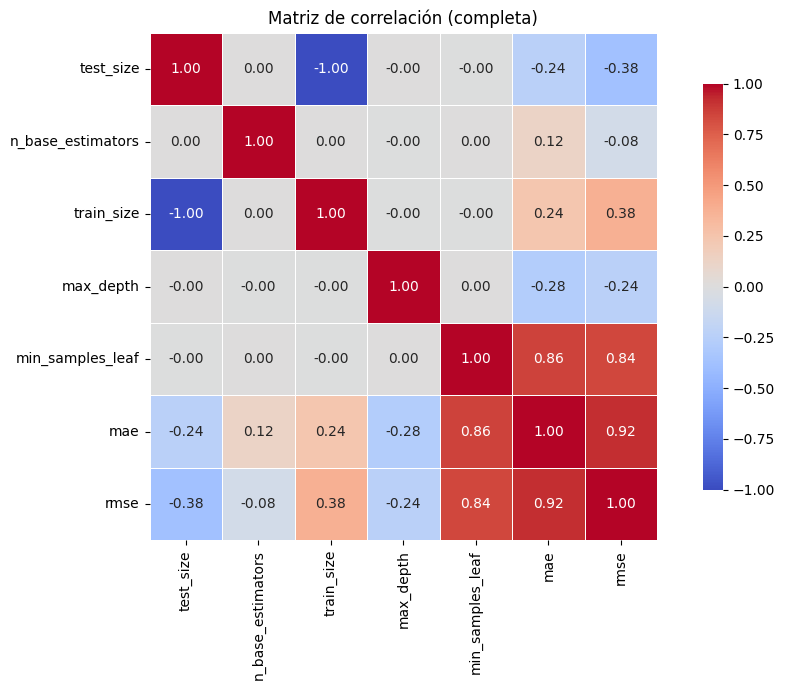

In [ ]:
import numpy as np  # 

# columnas numéricas
num_cols = df.select_dtypes(include="number").columns

# descarta las que tengan varianza ~0 o estén totalmente vacías
valid_cols = [
    c for c in num_cols
    if df[c].nunique(dropna=True) > 1          # al menos 2 valores distintos
       and df[c].notna().any()                 # contiene algún no-nulo
]

# añade las métricas que te interesen
cols_to_corr = valid_cols 

corr = df[cols_to_corr].corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))

sns.heatmap(
    corr,                 # tu DataFrame de correlaciones
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)

plt.title("Matriz de correlación (completa)")
plt.tight_layout()
plt.show()



In [31]:
# 4.3 top / worst-N
def show_top(metric, k=5):
    best  = df.nsmallest(k, metric).reset_index(drop=True)
    worst = df.nlargest(k, metric ).reset_index(drop=True)
    print(f"\n🔝 Top-{k} por «{metric}»");  display(best)
    print(f"\n🔻 Peor-{k} por «{metric}»"); display(worst)
show_top("rmse");  show_top("mae")



🔝 Top-5 por «rmse»


,test_size,sample_size,fl_epochs,n_base_estimators,n_incremental_estimators,train_size,max_depth,max_features,min_samples_leaf,mae,rmse
0,0.3,NaN,2,100,10,0.7,10.0,NaN,1,122.223939,174.742965
1,0.3,NaN,2,200,10,0.7,10.0,NaN,1,123.048500,175.366384
2,0.3,NaN,2,200,10,0.7,NaN,NaN,1,121.749965,175.531508
3,0.3,NaN,2,100,10,0.7,NaN,NaN,1,122.488167,176.277767
4,0.2,NaN,2,100,10,0.8,NaN,NaN,1,122.493558,177.261871



🔻 Peor-5 por «rmse»


,test_size,sample_size,fl_epochs,n_base_estimators,n_incremental_estimators,train_size,max_depth,max_features,min_samples_leaf,mae,rmse
0,0.2,NaN,2,100,10,0.8,NaN,NaN,5,127.995622,187.761208
1,0.2,NaN,2,100,10,0.8,10.0,NaN,5,128.030391,186.559238
2,0.2,NaN,2,100,10,0.8,5.0,NaN,5,129.101509,186.446729
3,0.2,NaN,2,200,10,0.8,5.0,NaN,5,128.031194,186.056160
4,0.2,NaN,2,200,10,0.8,NaN,NaN,5,128.556295,185.530895



🔝 Top-5 por «mae»


,test_size,sample_size,fl_epochs,n_base_estimators,n_incremental_estimators,train_size,max_depth,max_features,min_samples_leaf,mae,rmse
0,0.3,NaN,2,200,10,0.7,NaN,NaN,1,121.749965,175.531508
1,0.2,NaN,2,200,10,0.8,NaN,NaN,1,122.213593,177.643445
2,0.3,NaN,2,100,10,0.7,10.0,NaN,1,122.223939,174.742965
3,0.3,NaN,2,100,10,0.7,NaN,NaN,1,122.488167,176.277767
4,0.2,NaN,2,100,10,0.8,NaN,NaN,1,122.493558,177.261871



🔻 Peor-5 por «mae»


,test_size,sample_size,fl_epochs,n_base_estimators,n_incremental_estimators,train_size,max_depth,max_features,min_samples_leaf,mae,rmse
0,0.2,NaN,2,100,10,0.8,5.0,NaN,5,129.101509,186.446729
1,0.2,NaN,2,200,10,0.8,NaN,NaN,5,128.556295,185.530895
2,0.2,NaN,2,200,10,0.8,5.0,NaN,5,128.031194,186.056160
3,0.2,NaN,2,100,10,0.8,10.0,NaN,5,128.030391,186.559238
4,0.2,NaN,2,100,10,0.8,NaN,NaN,5,127.995622,187.761208


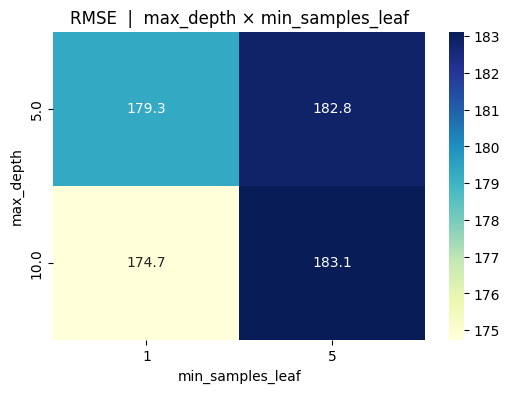

In [32]:
# 4.4 mapa 2-D de ejemplo
if {"max_depth","min_samples_leaf"}.issubset(df.columns):
    pivot = (df
             .pivot_table(index="max_depth",
                          columns="min_samples_leaf",
                          values="rmse",
                          aggfunc="min"))
    plt.figure(figsize=(6,4))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
    plt.title("RMSE  |  max_depth × min_samples_leaf")
    plt.ylabel("max_depth");  plt.xlabel("min_samples_leaf")
    plt.show()


🏆  Mejor configuración:
   test_size                     0.300000
   sample_size                        NaN
   fl_epochs                     2.000000
   n_base_estimators           100.000000
   n_incremental_estimators     10.000000
   train_size                    0.700000
   max_depth                    10.000000
   max_features                       NaN
   min_samples_leaf              1.000000
   mae                         122.223939
   rmse                        174.742965
→ Modelo cargado: results\grid_runs\run_01\retailer_region\20250619_141443\model.pkl


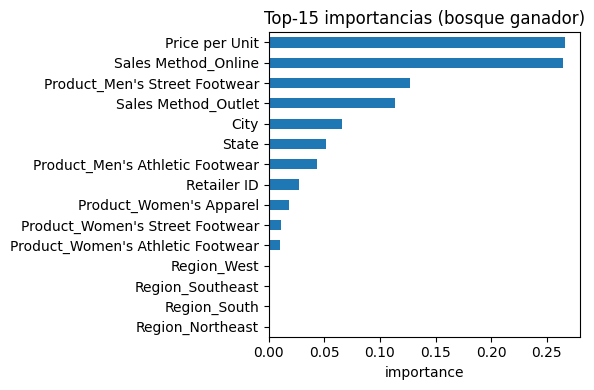

In [33]:
# 4.6 bosque ganador
best_row = df.loc[df["rmse"].idxmin()]
exp_id   = best_row.name + 1               # DataFrame index → 1-based id
run_dir  = Path(f"results/grid_runs/run_{exp_id:02d}")

# tu estructura real: run_xx / <scheme> / <timestamp> / model.pkl
model_pkl = next(run_dir.rglob("model.pkl"), None)
if model_pkl is None:
    print(f"⚠️  No se encontró model.pkl dentro de {run_dir}")
else:
    print(f"\n🏆  Mejor configuración:\n{indent(best_row.to_string(), '   ')}")
    print(f"→ Modelo cargado: {model_pkl}")

    with open(model_pkl, "rb") as f:
        rf = pickle.load(f)

    feat_names = json.loads(Path("artefactos/template_cols.json").read_text())

    # importancias

    # -- aseguramos que longitudes coinciden ------------------------------
    n_feats_rf   = rf.n_features_in_              # = len(rf.feature_importances_)
    n_feats_json = len(feat_names)

    if n_feats_rf != n_feats_json:
        print(f"⚠️  El modelo tiene {n_feats_rf} features "
            f"pero el template tiene {n_feats_json}. "
            "Ajustando automáticamente…")

        if n_feats_rf < n_feats_json:            # sobran nombres ➜ recortamos
            feat_names = feat_names[:n_feats_rf]
        else:                                    # faltan nombres ➜ generamos dummy
            feat_names += [f"_feat_{i}" for i in range(n_feats_rf - n_feats_json)]

    imp = (pd.Series(rf.feature_importances_, index=feat_names)
             .nlargest(15).sort_values())
    plt.figure(figsize=(6,4))
    imp.plot(kind="barh")
    plt.title("Top-15 importancias (bosque ganador)")
    plt.xlabel("importance")
    plt.tight_layout();  plt.show()


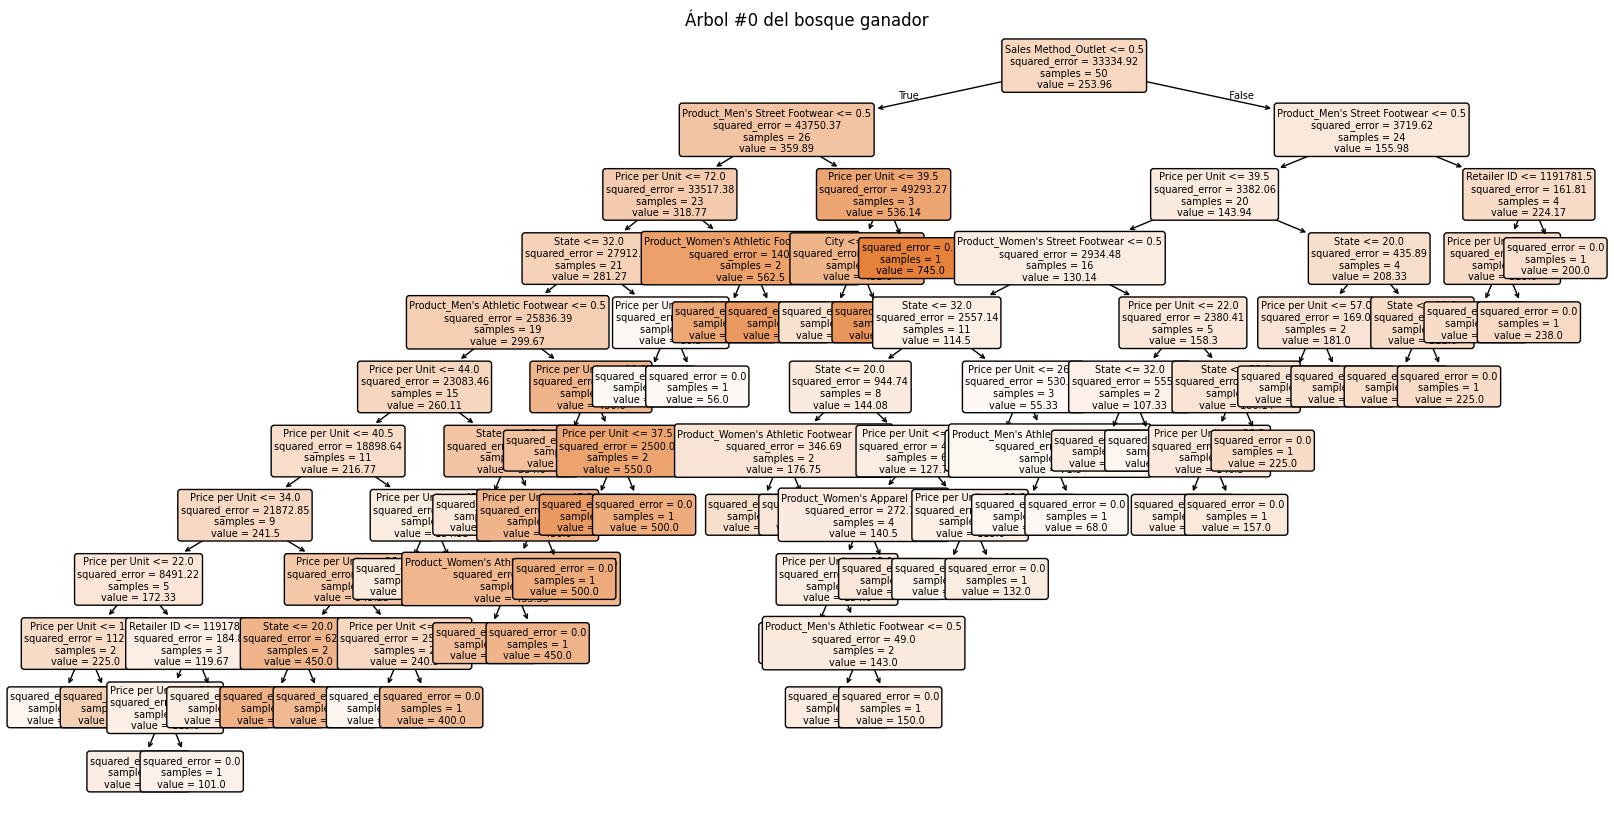

In [34]:
    # 4.6 un árbol concreto
    tree_idx = 0
    plt.figure(figsize=(20,10))
    plot_tree(rf.estimators_[tree_idx],
              feature_names=feat_names,
              filled=True, rounded=True,
              precision=2, fontsize=7)
    plt.title(f"Árbol #{tree_idx} del bosque ganador")
    plt.show()
